# PART C

In [1]:
#import required libraries - we do need the models, flatten, dense, input layers 
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

In [2]:
# Create a VGG19 model 
IMAGE_SIZE = [224, 224]
vgg = VGG19(weights='imagenet', include_top=True) 
vgg.summary()

574726144/574710816 [==============================] - 16s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [12]:
from keras.preprocessing.image import load_img
from google.colab import drive
drive.mount("/content/gdrive")
# load an image from drive
image = load_img('/content/gdrive/MyDrive/eagle.jpg', target_size=(224, 224))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


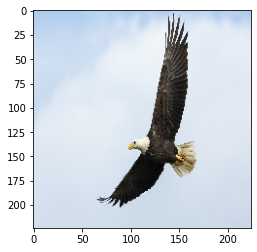

In [13]:
plt.imshow(image)

In [4]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

In [5]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [6]:
from keras.applications.vgg19 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

In [9]:
# predict the probability across all output classes
yhat = vgg.predict(image)

In [10]:
from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probabilities
# print the classification
print('%s (%.2f%%)' % (label[0][0][1], label[0][0][2]*100))
print('%s (%.2f%%)' % (label[0][1][1], label[0][1][2]*100))
print('%s (%.2f%%)' % (label[0][2][1], label[0][2][2]*100))


49152/35363 [=========================================] - 0s 0us/step
bald_eagle (99.81%)
kite (0.16%)
vulture (0.02%)


# PART D

In [ ]:
import tensorflow as tf

In [ ]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


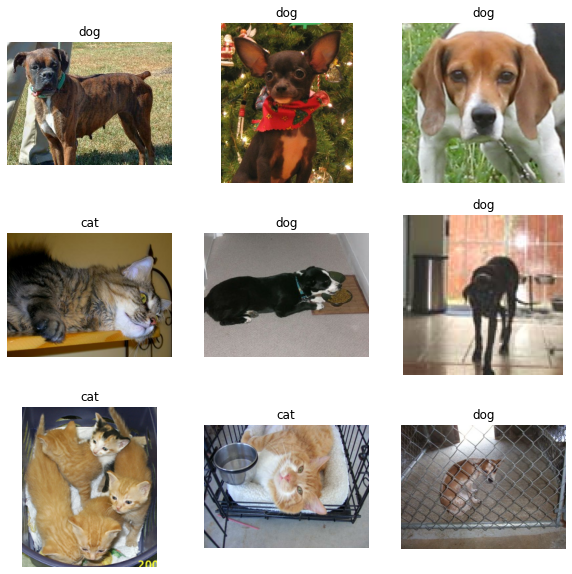

In [ ]:
import matplotlib.pyplot as plt
# show 9 random images of the dataset
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    if(label):
      plt.title("dog")
    else:
      plt.title("cat")
    plt.axis("off")

In [ ]:
# preprocess data
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
validation_ds = validation_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [ ]:
# reshape data
size = (224, 224)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


In [ ]:
# batching data
batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


In [ ]:
# Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
IMAGE_SIZE = [224, 224] #Default image size for VGG19
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False) 
vgg.trainable = False
x = Flatten()(vgg.output) # output obtained on vgg19 is now flattened. 
prediction = Dense(1)(x) # we have 2 classes, and so, the prediction is being done on 2 classes
#Creating model object 
model = Model(vgg.inputs, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import keras

In [ ]:
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
history = model.fit(train_ds, validation_data=validation_ds, epochs=10, batch_size=32)

Epoch 1/10
291/291 [==============================] - 78s 256ms/step - loss: 1.1369 - binary_accuracy: 0.9464 - val_loss: 0.9359 - val_binary_accuracy: 0.9630
Epoch 2/10
291/291 [==============================] - 69s 237ms/step - loss: 0.4663 - binary_accuracy: 0.9775 - val_loss: 1.4046 - val_binary_accuracy: 0.9604
Epoch 3/10
291/291 [==============================] - 69s 236ms/step - loss: 0.2159 - binary_accuracy: 0.9912 - val_loss: 1.1858 - val_binary_accuracy: 0.9729
Epoch 4/10
291/291 [==============================] - 69s 237ms/step - loss: 0.0851 - binary_accuracy: 0.9941 - val_loss: 1.1356 - val_binary_accuracy: 0.9733
Epoch 5/10
291/291 [==============================] - 69s 238ms/step - loss: 0.0827 - binary_accuracy: 0.9959 - val_loss: 1.2477 - val_binary_accuracy: 0.9699
Epoch 6/10
291/291 [==============================] - 69s 236ms/step - loss: 0.0598 - binary_accuracy: 0.9967 - val_loss: 1.5850 - val_binary_accuracy: 0.9686
Epoch 7/10
291/291 [==========================

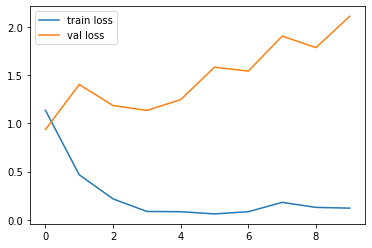

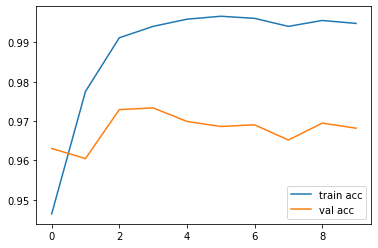

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss on train and validation data
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')
# accuracies on train and validation data
plt.plot(history.history['binary_accuracy'], label='train acc')
plt.plot(history.history['val_binary_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save model
from tensorflow.keras.models import load_model
model.save('transfer_VGG19.h5')

In [ ]:
y_pred = model.predict(test_ds)

In [ ]:
_, _, test = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

In [ ]:
test_label = list(map(lambda x: x[1], test))

In [ ]:
y_label= [i.numpy() for i in test_label]

In [ ]:
y_pred=np.heaviside(y_pred,0)

In [ ]:
y_label=np.array(y_label)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_label, y_pred)

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy on test data
accuracy = accuracy_score(y_label, y_pred)
print("Accuracy on test data is:", accuracy)

Accuracy on test data is: 0.9729148753224419


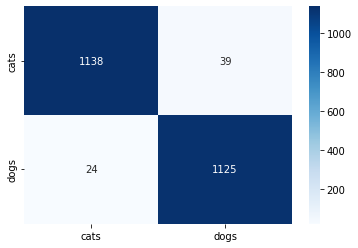

In [ ]:
import seaborn as sns
# plot confusion matrix of the test data
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",xticklabels=["cats","dogs"],yticklabels=["cats","dogs"])
